This notebook compares three different Conjugate Gradient algorithms to solve a Block-Toeplitz Toeplitz-Block (BTTB) system of the Equivalent-Layer technique for magnetic data.

When magnetic data $d^o$ is placed on a regular grid the matrix $A$ has a structure knows as Block-Toeplitz Toeplitz-Block or (BTTB). Any BTTB matrix can be transformed into a Block-Circulant Circulant-Block matrix (BCCB), which can be easily diagonalized by taking the 2-D FFT of its first column [1]. This property can be used to fast calculate the forward problem of each iteration necessary to estimate the physical property.

The first algorithm is a simple Conjugate Gradient method. It can be seen for the results that the system is very unstable.

The second algorithm is a Conjugate Gradient Least Square method. It can be seen that it does not converge.

The third algorithm is a Conjugate Gradient Least Square with Tikhonov order 0 regularization, where the regularization parameter is calculated iteratively by a inner loop. More tests need to be done with this algorithm, but the convergence is highly improved. This algorithm is based on the paper by Zhang, J., & Wang, Q., 2010. [2]

[1] Chan, R. H.-F., and X.-Q. Jin, 2007, An introduction to iterative toeplitz solvers: SIAM,5.

[2] Zhang, J., & Wang, Q., 2010. An iterative conjugate gradient regularization method for image restoration. Journal of Information and Computing Science, 5(1), 055-062.

## Import Built-in Python modules and functions

In [2]:
import numpy as np
import sys
sys.path.append('C:/ProgramData/Anaconda2/Lib/site-packages/fatiando')
from fatiando import mesher, gridder, utils
from fatiando.gravmag import polyprism
from scipy.linalg import toeplitz
from sys import getsizeof
from timeit import default_timer as time
from matplotlib import pyplot as plt
from numpy.linalg import inv
%matplotlib inline

## Import User Functions in the functions_eq_mag.py file

In [3]:
import functions_eq_mag as fc

## Create the model - Uses Fatiando a Terra polyprism modeling

In [4]:
# Create a regular grid at 0m height
area = [-5000., 5000., -4000., 4000.]
shape = (50, 50)
N = shape[0]*shape[1]
xi, yi, zi = gridder.regular(area, shape, z=000.)

# Equivalent Layer
xj, yj, zj = gridder.regular(area, shape, z=900)

# Model
verts1 = [[-1000, -2000], [1000, -2000], [1000, 2000], [-1000, 2000]]
model_tf = [mesher.PolygonalPrism(verts1, 1000., 1500., props={'magnetization':[2,2,0]})]

In [5]:
# Magnetic Configuration
inc0 = np.deg2rad(0.)
dec0 = np.deg2rad(45.)
inten,inc,dec = utils.vec2ang([2,2,0])
inc = np.deg2rad(inc)
dec = np.deg2rad(dec)
F = np.array([np.cos(inc0)*np.cos(dec0), np.cos(inc0)*np.sin(dec0), np.sin(inc0)])
h = np.array([np.cos(inc)*np.cos(dec), np.cos(inc)*np.sin(dec), np.sin(inc)])

In [6]:
tf = polyprism.tf(xi, yi, zi, model_tf, inc0, dec0)
tf = utils.contaminate(tf, 0.015, seed=0, percent=True)

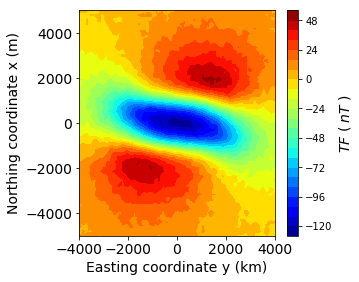

In [7]:
plt.figure(figsize=(5,4))

plt.tricontourf(yi,xi,tf,22,cmap='jet')
cb = plt.colorbar(shrink=1)
cb.set_label('$TF$ ( $nT$ )', rotation=90, fontsize=14)
plt.xlim(np.min(yi),np.max(yi))
plt.ylim(np.min(xi),np.max(xi))
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Easting coordinate y (km)', fontsize=14)
plt.ylabel('Northing coordinate x (m)', fontsize=14)
plt.tight_layout(True)
#plt.savefig('figures/classic_fast.png', dpi=300)

# Classic Forward Problem Construction - MAG

In [6]:
# Calculo da matriz de sensibilidade
s = time()
p_c, tf_c = fc.classic_mag(xi,yi,zi,zj,F,h,N,tf)
e = time()
tcpu = e - s
print tcpu

4.2954586


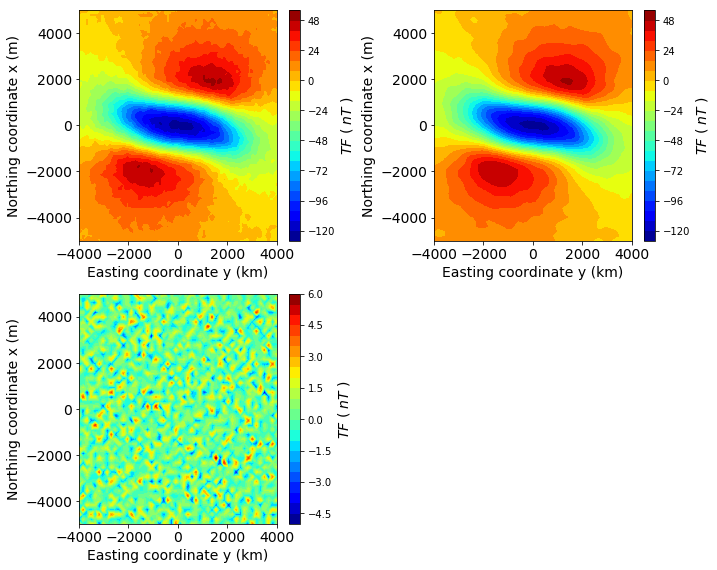

In [7]:
plt.figure(figsize=(10,8))

plt.subplot(221)
plt.tricontourf(yi,xi,tf,22,cmap='jet')
cb = plt.colorbar(shrink=1)
cb.set_label('$TF$ ( $nT$ )', rotation=90, fontsize=14)
plt.xlim(np.min(yi),np.max(yi))
plt.ylim(np.min(xi),np.max(xi))
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Easting coordinate y (km)', fontsize=14)
plt.ylabel('Northing coordinate x (m)', fontsize=14)

plt.subplot(222)
plt.tricontourf(yi,xi,tf_c,22,cmap='jet')
cb = plt.colorbar(shrink=1)
cb.set_label('$TF$ ( $nT$ )', rotation=90, fontsize=14)
plt.xlim(np.min(yi),np.max(yi))
plt.ylim(np.min(xi),np.max(xi))
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Easting coordinate y (km)', fontsize=14)
plt.ylabel('Northing coordinate x (m)', fontsize=14)

delta_tf = tf-tf_c
plt.subplot(223)
plt.tricontourf(yi,xi,delta_tf,22,cmap='jet')
cb = plt.colorbar(shrink=1)
cb.set_label('$TF$ ( $nT$ )', rotation=90, fontsize=14)
plt.xlim(np.min(yi),np.max(yi))
plt.ylim(np.min(xi),np.max(xi))
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Easting coordinate y (km)', fontsize=14)
plt.ylabel('Northing coordinate x (m)', fontsize=14)
plt.tight_layout(True)
#plt.savefig('figures/classic_fast.png', dpi=300)

### Parameter Plot

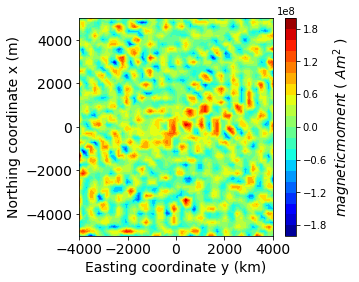

In [8]:
plt.figure(figsize=(5,4))

plt.tricontourf(yi,xi,p_c,22,cmap='jet')
cb = plt.colorbar(shrink=1)
cb.set_label('$magnetic moment$ ( $Am^2$ )', rotation=90, fontsize=14)
plt.xlim(np.min(yi),np.max(yi))
plt.ylim(np.min(xi),np.max(xi))
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Easting coordinate y (km)', fontsize=14)
plt.ylabel('Northing coordinate x (m)', fontsize=14)
plt.tight_layout(True)
#plt.savefig('figures/classic_fast.png', dpi=300)

# Conjugate Gradient

### BCCB  matrix-vector product with Linear CG implementation - no conditioning

In [9]:
w = time()

itmax = 4
p_cg,dobs_cg = fc.cg_eq_bccb_mag(xi,yi,zi,zj,shape,tf,F,h,itmax)
t = time()
tcpu = t - w
print tcpu

0.0131098


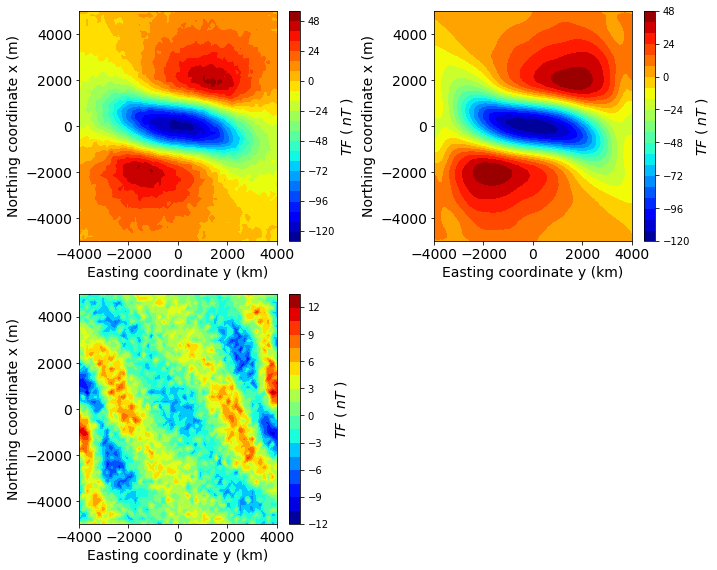

In [10]:
plt.figure(figsize=(10,8))

plt.subplot(221)
plt.tricontourf(yi,xi,tf,22,cmap='jet')
cb = plt.colorbar(shrink=1)
cb.set_label('$TF$ ( $nT$ )', rotation=90, fontsize=14)
plt.xlim(np.min(yi),np.max(yi))
plt.ylim(np.min(xi),np.max(xi))
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Easting coordinate y (km)', fontsize=14)
plt.ylabel('Northing coordinate x (m)', fontsize=14)

plt.subplot(222)
plt.tricontourf(yi,xi,dobs_cg,22,cmap='jet')
cb = plt.colorbar(shrink=1)
cb.set_label('$TF$ ( $nT$ )', rotation=90, fontsize=14)
plt.xlim(np.min(yi),np.max(yi))
plt.ylim(np.min(xi),np.max(xi))
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Easting coordinate y (km)', fontsize=14)
plt.ylabel('Northing coordinate x (m)', fontsize=14)

delta_tf = tf-dobs_cg
plt.subplot(223)
plt.tricontourf(yi,xi,delta_tf,22,cmap='jet')
cb = plt.colorbar(shrink=1)
cb.set_label('$TF$ ( $nT$ )', rotation=90, fontsize=14)
plt.xlim(np.min(yi),np.max(yi))
plt.ylim(np.min(xi),np.max(xi))
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Easting coordinate y (km)', fontsize=14)
plt.ylabel('Northing coordinate x (m)', fontsize=14)
plt.tight_layout(True)
#plt.savefig('figures/classic_fast.png', dpi=300)

### Parameter Plot

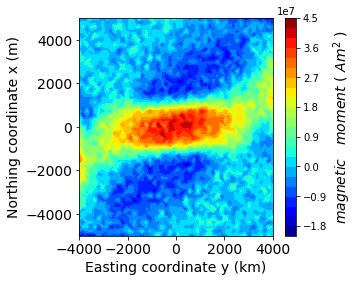

In [11]:
plt.figure(figsize=(5,4))

plt.tricontourf(yi,xi,p_cg,22,cmap='jet')
cb = plt.colorbar(shrink=1)
cb.set_label('$magnetic \quad moment$ ( $Am^2$ )', rotation=90, fontsize=14)
plt.xlim(np.min(yi),np.max(yi))
plt.ylim(np.min(xi),np.max(xi))
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Easting coordinate y (km)', fontsize=14)
plt.ylabel('Northing coordinate x (m)', fontsize=14)
plt.tight_layout(True)
#plt.savefig('figures/classic_fast.png', dpi=300)

### CG Convergence

In [12]:
itmax = np.arange(1,50,1)
res_list = []
for k in itmax:
    p_cg,dobs_cg = fc.cg_eq_bccb_mag(xi,yi,zi,zj,shape,tf,F,h,k)
    norm_res = np.linalg.norm(tf-dobs_cg)
    res_list.append(norm_res)

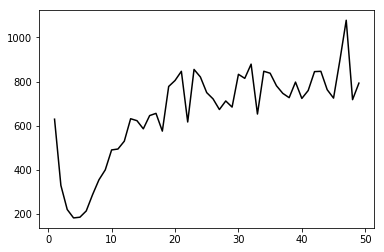

In [13]:
plt.plot(itmax,res_list, 'k-')

# Conjugate Gradient Least Square

### BCCB  matrix-vector product with Linear CGLS implementation - no conditioning

In [14]:
w = time()
itmax = 5
p_cgls,dobs_cgls = fc.cgls_eq_bccb_mag(xi,yi,zi,zj,shape,tf,F,h,itmax)
t = time()
tcpu = t - w
print tcpu

0.0139


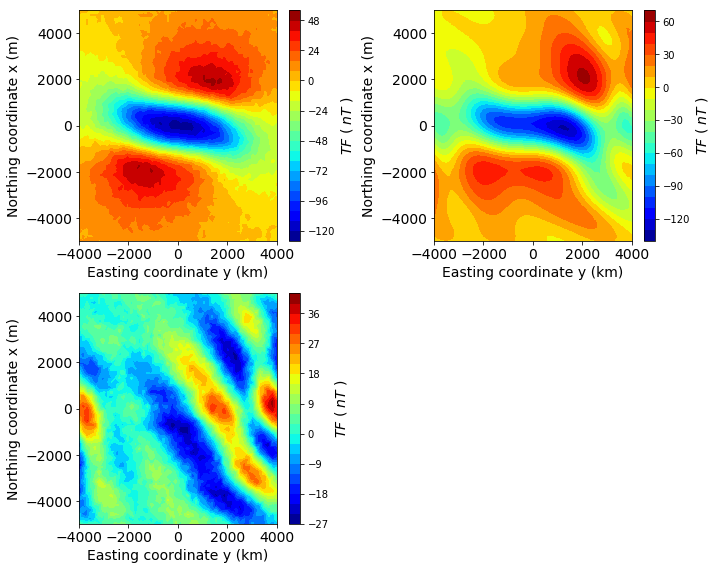

In [15]:
plt.figure(figsize=(10,8))

plt.subplot(221)
plt.tricontourf(yi,xi,tf,22,cmap='jet')
cb = plt.colorbar(shrink=1)
cb.set_label('$TF$ ( $nT$ )', rotation=90, fontsize=14)
plt.xlim(np.min(yi),np.max(yi))
plt.ylim(np.min(xi),np.max(xi))
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Easting coordinate y (km)', fontsize=14)
plt.ylabel('Northing coordinate x (m)', fontsize=14)

plt.subplot(222)
plt.tricontourf(yi,xi,dobs_cgls,22,cmap='jet')
cb = plt.colorbar(shrink=1)
cb.set_label('$TF$ ( $nT$ )', rotation=90, fontsize=14)
plt.xlim(np.min(yi),np.max(yi))
plt.ylim(np.min(xi),np.max(xi))
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Easting coordinate y (km)', fontsize=14)
plt.ylabel('Northing coordinate x (m)', fontsize=14)

delta_tf = tf-dobs_cgls
plt.subplot(223)
plt.tricontourf(yi,xi,delta_tf,22,cmap='jet')
cb = plt.colorbar(shrink=1)
cb.set_label('$TF$ ( $nT$ )', rotation=90, fontsize=14)
plt.xlim(np.min(yi),np.max(yi))
plt.ylim(np.min(xi),np.max(xi))
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Easting coordinate y (km)', fontsize=14)
plt.ylabel('Northing coordinate x (m)', fontsize=14)
plt.tight_layout(True)
#plt.savefig('figures/classic_fast.png', dpi=300)

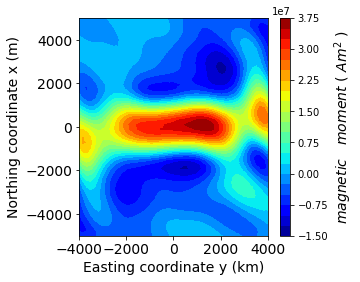

In [16]:
plt.figure(figsize=(5,4))

plt.tricontourf(yi,xi,p_cgls,22,cmap='jet')
cb = plt.colorbar(shrink=1)
cb.set_label('$magnetic \quad moment$ ( $Am^2$ )', rotation=90, fontsize=14)
plt.xlim(np.min(yi),np.max(yi))
plt.ylim(np.min(xi),np.max(xi))
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Easting coordinate y (km)', fontsize=14)
plt.ylabel('Northing coordinate x (m)', fontsize=14)
plt.tight_layout(True)
#plt.savefig('figures/classic_fast.png', dpi=300)

### CGLS Convergence

In [17]:
itmax = np.arange(1,50,1)
res_list_ls = []
for k in itmax:
    p_cgls,dobs_cgls = fc.cgls_eq_bccb_mag(xi,yi,zi,zj,shape,tf,F,h,k)
    norm_res_ls = np.linalg.norm(tf-dobs_cgls)
    res_list_ls.append(norm_res_ls)

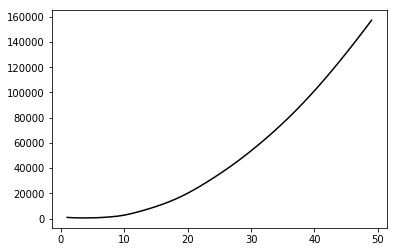

In [18]:
plt.plot(itmax,res_list_ls, 'k-')

# Conjugate Gradient Least Square with Tikhonov Order 0

### BCCB matrix-vector product with Linear CGLS implementation - no conditioning

In [24]:
w = time()
itmax = 100
p_cgls_0,dobs_cgls_0 = fc.cgls_eq_bccb_mag_tikho_0(xi,yi,zi,zj,shape,tf,F,h,itmax)
t = time()
tcpu = t - w
print tcpu

0.561619


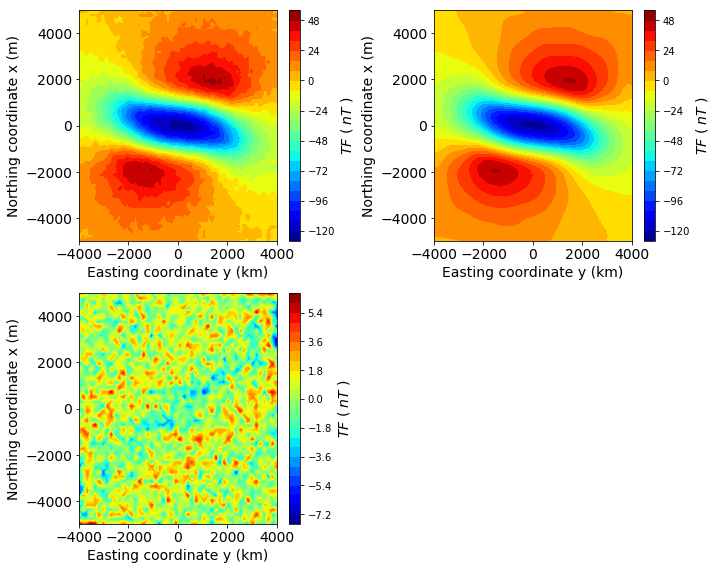

In [25]:
plt.figure(figsize=(10,8))

plt.subplot(221)
plt.tricontourf(yi,xi,tf,22,cmap='jet')
cb = plt.colorbar(shrink=1)
cb.set_label('$TF$ ( $nT$ )', rotation=90, fontsize=14)
plt.xlim(np.min(yi),np.max(yi))
plt.ylim(np.min(xi),np.max(xi))
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Easting coordinate y (km)', fontsize=14)
plt.ylabel('Northing coordinate x (m)', fontsize=14)

plt.subplot(222)
plt.tricontourf(yi,xi,dobs_cgls_0,22,cmap='jet')
cb = plt.colorbar(shrink=1)
cb.set_label('$TF$ ( $nT$ )', rotation=90, fontsize=14)
plt.xlim(np.min(yi),np.max(yi))
plt.ylim(np.min(xi),np.max(xi))
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Easting coordinate y (km)', fontsize=14)
plt.ylabel('Northing coordinate x (m)', fontsize=14)

delta_tf = tf-dobs_cgls_0
plt.subplot(223)
plt.tricontourf(yi,xi,delta_tf,22,cmap='jet')
cb = plt.colorbar(shrink=1)
cb.set_label('$TF$ ( $nT$ )', rotation=90, fontsize=14)
plt.xlim(np.min(yi),np.max(yi))
plt.ylim(np.min(xi),np.max(xi))
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Easting coordinate y (km)', fontsize=14)
plt.ylabel('Northing coordinate x (m)', fontsize=14)
plt.tight_layout(True)
#plt.savefig('figures/classic_fast.png', dpi=300)

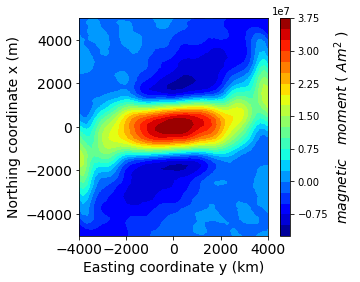

In [21]:
plt.figure(figsize=(5,4))

plt.tricontourf(yi,xi,p_cgls_0,22,cmap='jet')
cb = plt.colorbar(shrink=1)
cb.set_label('$magnetic \quad moment$ ( $Am^2$ )', rotation=90, fontsize=14)
plt.xlim(np.min(yi),np.max(yi))
plt.ylim(np.min(xi),np.max(xi))
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Easting coordinate y (km)', fontsize=14)
plt.ylabel('Northing coordinate x (m)', fontsize=14)
plt.tight_layout(True)
#plt.savefig('figures/classic_fast.png', dpi=300)

### CGLS with Tikhonov Order 0 Convergence

In [26]:
itmax = np.arange(1,50,1)
res_list_ls_0 = []
for k in itmax:
    p_cgls_0,dobs_cgls_0 = fc.cgls_eq_bccb_mag_tikho_0(xi,yi,zi,zj,shape,tf,F,h,k)
    norm_res_ls_0 = np.linalg.norm(tf-dobs_cgls_0)
    res_list_ls_0.append(norm_res_ls_0)

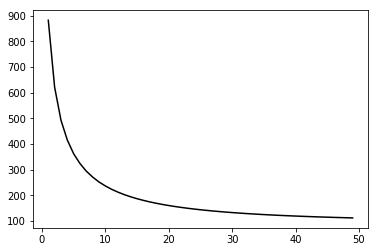

In [27]:
plt.plot(itmax,res_list_ls_0, 'k-')